In [1]:
#!pip install -r requirements.txt

In [159]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = [16,6]

## Imports

In [3]:
DATA_ROOT = os.path.abspath('../../../../datasets/thick_smears_150')
GT_ROOT  = os.path.join(DATA_ROOT,'GT_updated')
all_files = glob.glob(os.path.join(GT_ROOT,'*','*.txt'))
#all_images = glob.glob(os.path.join(DATA_ROOT,'*','*.jpg'))
all_images = [p.replace('/GT_updated','').replace('.txt','.jpg') for p in all_files]

## Load mask info

In [4]:
def read_info(path):
    # Read df from text file (minus header)
    columns = ['id', 'classification', 'comments', 'circle_or_point', 'circ_point_num',
               'y_centre', 'x_centre', 'y_point_circle', 'x_point_circle'] #Note: x & y recorded backwards
    temp = pd.read_csv(path, names = columns, skiprows=1)
    
    # Assign a unique path
    p = Path(path)   # Better to use this library than DIY
    temp.insert(loc = 1,    # Insert in position 1 (just after column "id")
                column = 'patient_id',
                value = p.parent.name
               )
    temp.insert(loc = 2,    # Insert in position 2
                column = 'timestamp',
                value = p.stem
               )
    
    # Parse header to retrieve metadata
    with open(path) as file:
        o,h,w = file.readline().strip().split(',')

    # Add metadata
    temp['n_objects'] = int(o)
    temp['height'], temp['width'] = int(h),int(w)
    
    return temp

df = pd.concat(map(read_info,all_files))  # Do a map to avoid creating the list of df explicitely

# Correct the coordinates (realign with opencv referential)
df['y_centre'] = df['height']-df['y_centre']
df['y_point_circle'] = df['height']-df['y_point_circle']

df['x_centre'] = df['width']-df['x_centre']
df['x_point_circle'] = df['width']-df['x_point_circle']

In [5]:
def calc_radius(x_diff,y_diff):
    return np.sqrt(np.power(x_diff,2) + np.power(y_diff,2))

# Calculate radius
df['radius'] = calc_radius(df['x_centre'] - df['x_point_circle'],df['y_centre'] - df['y_point_circle'])      
df['radius'] = df['radius']*(df['circle_or_point']=='Circle')  # Will set to 0 when Point

# Cast all numerical columns to int, this will round them
df[df.select_dtypes('number').columns] = df.select_dtypes('number').fillna(0).astype('int')
df.head()

,id,patient_id,timestamp,classification,comments,circle_or_point,circ_point_num,y_centre,x_centre,y_point_circle,x_point_circle,n_objects,height,width,radius
0,1-2,TF60_15_18,20170816_093951,Parasite,No_Comment,Circle,2,1513,1201,1510,1184,24,4032,3024,17
1,1-3,TF60_15_18,20170816_093951,Parasite,No_Comment,Circle,2,2104,1330,2104,1310,24,4032,3024,19
2,1-10,TF60_15_18,20170816_093951,White_Blood_Cell,No_Comment,Point,1,2900,2524,0,0,24,4032,3024,0
3,1-11,TF60_15_18,20170816_093951,White_Blood_Cell,No_Comment,Point,1,2712,2069,0,0,24,4032,3024,0
4,1-12,TF60_15_18,20170816_093951,White_Blood_Cell,No_Comment,Point,1,2741,1803,0,0,24,4032,3024,0


In [6]:
print(
    df.height.value_counts(),
    df.width.value_counts(),
    sep='\n'
)

4032    120441
Name: height, dtype: int64
3024    120441
Name: width, dtype: int64


All images have the exact same size, we could have not included the image size in the df

## Create mask from center and radius

### One example

In [7]:
# Grab an example
temp = df.head(10)
temp = temp[temp.circle_or_point=='Circle'].to_dict()
k = 0

x = temp['x_centre'][k]
y = temp['y_centre'][k]
r = temp['radius'][k]
p = temp['patient_id'][k]
t = temp['timestamp'][k]

x,y,r,p,t

(1201, 1513, 17, 'TF60_15_18', '20170816_093951')

In [8]:
#Generate the path of the image to load
img_path = os.path.join(DATA_ROOT,p,t+'.jpg')
img_path

'/Users/Alex/Google Drive/AI4good/datasets/thick_smears_150/TF60_15_18/20170816_093951.jpg'

(4032, 3024, 3)


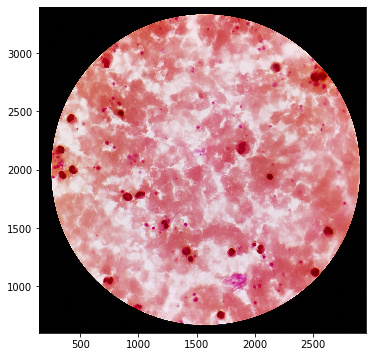

In [9]:
img = cv2.imread(img_path) 
print(img.shape)

plt.imshow(img);
plt.xlim(150,2950);
plt.ylim(600,3400);

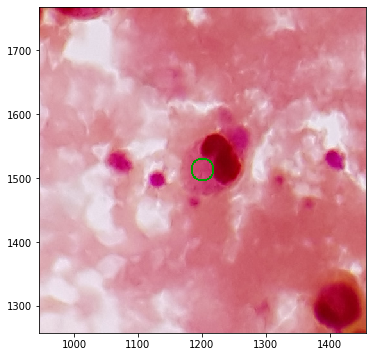

In [10]:
#background = np.zeros((4032,3024), np.uint8)

# Add the outline
new_img = cv2.circle(img,
                     center = (x,y),  # Because of opencv standard, might be (y,x) instead ????
                     radius = r,
                     color = (0,160,0), # Darkish green
                     thickness = 2
                    )

# Add the filling
'''
new_img = cv2.circle(new_img,
                          center = (x,y),
                           radius = r,
                           color = [0,255,0], # Light green
                           thickness = cv2.FILLED  # Will draw a filled circle
                          )
'''

zoom = 15*r
plt.imshow(new_img);
plt.xlim(x-zoom,x+zoom);
plt.ylim(y-zoom,y+zoom);

### Create all masks for each image

In [11]:
def draw_circle(img, x, y, radius, color = (0,160,0), thickness = 2):
    return cv2.circle(img,
                      center = (x,y),
                      radius = radius,
                      color = color,
                      thickness = thickness
                     )

In [270]:
for path in all_files[10:12]:
    # Extract unique ID pair
    p = Path(path)
    timestamp = p.stem
    patient = p.parent.name
        
    # Load the base image
    img = cv2.imread(os.path.join(DATA_ROOT,patient,timestamp+'.jpg'))
    
    # Filter relevant data
    # TODO - Make those indexes
    idx = (df.patient_id == patient)&(df.timestamp == timestamp)
    data = df[idx]
    
    # Draw all the circles
    for _,row in df[idx].iterrows():
        if row.radius>0:
            img = draw_circle(img,row.x_centre,row.y_centre,row.radius)
        
            # For displyaing purposes only
            x,y,r = row.x_centre,row.y_centre,row.radius
    # Save the image

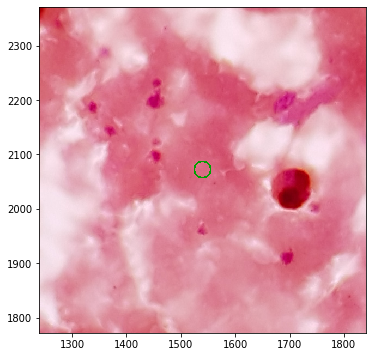

In [271]:
plt.imshow(img);

zoom = 20*r
plt.xlim(x-zoom,x+zoom);
plt.ylim(y-zoom,y+zoom);

## Crop images

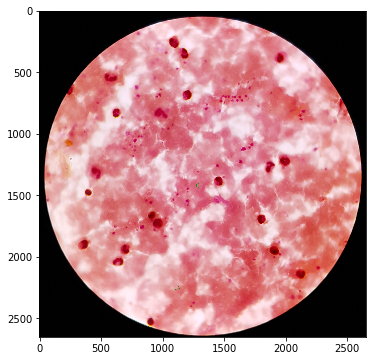

In [272]:
#Basic cropping
def crop(img):
    return img[650:3300,250:2900]

plt.imshow(crop(img));

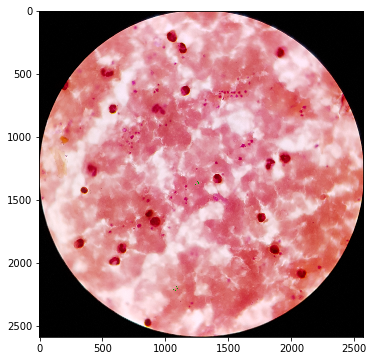

In [289]:
# Background detection

def smart_crop(img, threshold=50):
    img_thresholded = img.mean(axis=2)>threshold
    
    temp_x = img_thresholded.mean(axis=0).nonzero()[0]
    x_min, x_max = temp_x[0], temp_x[-1]
    
    temp_y = img_thresholded.mean(axis=1).nonzero()[0]
    y_min, y_max = temp_y[0], temp_y[-1]
    
    cropped_img = img[y_min:y_max+1,x_min:x_max+1]
    
    return (cropped_img,(x_min,x_max,y_min,y_max))
    
plt.imshow(smart_crop(img)[0]);

## Cut and save smaller images

In [ ]:
zoom = 3  # Upsample by a factor 2
L = 224*zoom
window = int(0.7*L) # Leave some overlap, make windows smaller than input size

for i in tqdm(all_images):
    
    # Load base image
    p = Path(i)
    img,(x_min,x_max,y_min,y_max) = smart_crop(cv2.imread(i))
    h,w = img.shape[0],img.shape[1]
    
    # Create mask
    idx = (df.patient_id == p.parent.name)&(df.timestamp == p.stem)
    data = df[idx]
    # Draw all the circles on the blank mask
    mask = np.zeros((4032,3024))
    for _,row in df[idx].iterrows():
        if row.radius>0:
            mask = draw_circle(mask,row.x_centre,row.y_centre,row.radius,thickness=-1,color=1)
    mask = mask[y_min:y_max+1,x_min:x_max+1] # Cropping according to the image boundaries
    
    
    # Prepare the cutting indexes
    x_cuts = np.arange(0,w-L,window).astype(int)
    y_cuts = np.arange(0,h-L,window).astype(int)
    
    # Prepare the paths
    new_dir = os.path.join(*p.parts[:-3],f'thick_smears_150_x{zoom}',p.parts[-2],p.stem)
    Path(new_dir).mkdir(parents=True, exist_ok=True)
    
    # Main loop
    ground_truth = []
    for j,x in enumerate(x_cuts,1):
        for k,y in enumerate(y_cuts,1):
            temp = img[x:x+L,y:y+L,:]
            new_path = os.path.join(new_dir,f'{j}-{k}.jpg')
            cv2.imwrite(new_path,temp)
            
            # Label is true if any pixel of the cropped mask is non z ero
            label = mask[x:x+L,y:y+L].any()
            ground_truth.append({'id':f'{j}-{k}', 'label':label})
    
    pd.DataFrame(ground_truth).to_csv(os.path.join(new_dir,'ground_truth.csv'),index=False)